In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from collections import OrderedDict
import sys
import os
import numpy as np
import json
import scipy.io
from pyDOE import lhs
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
sys.path.insert(0, '/home/xiaoyang/WorkSpace/XiaoY/PINNs-TF2.0/PINNs/Utilities/')
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

In [2]:
np.random.seed(1234)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        self.layers = layers
        self.layer1 = nn.Sequential(nn.Linear(layers[0], layers[1]),nn.Tanh())
        self.layer2 = nn.Sequential(nn.Linear(layers[1], layers[2]),nn.Tanh())
        self.layer3 = nn.Sequential(nn.Linear(layers[2], layers[3]),nn.Tanh())
        self.layer4 = nn.Sequential(nn.Linear(layers[3], layers[4]),nn.Tanh())
        self.layer5 = nn.Sequential(nn.Linear(layers[4], layers[5]),nn.Tanh())
        self.layer6 = nn.Sequential(nn.Linear(layers[5], layers[6]),nn.Tanh())
        self.layer7 = nn.Sequential(nn.Linear(layers[6], layers[7]),nn.Tanh())
        self.layer8 = nn.Sequential(nn.Linear(layers[7], layers[8]),nn.Tanh())
        self.layer9 = nn.Sequential(nn.Linear(layers[8], layers[9]))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        return x

In [4]:
class RBFNN(DNN):
    def __init__(self, layers, X_train, Y_eaxct):
        super(RBFNN, self).__init__(layers)
        self.X_train = X_train
        self.Y_eaxct = Y_eaxct
        self.feature = 2 #输入数据的特征数
        self.hidden_size = 100 # 隐层节点的个数
        self.n_out = 1 #输出维数
        self.epoch = 0
        self.criterion = nn.MSELoss()
        self.dnn = DNN(layers)
        self.params = self.dnn.parameters()
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.params,lr=0.1,momentum=0.9)
       


    def loss_fun(self):
        self.optimizer.zero_grad()
        out = self.dnn(self.X_train)
        loss = self.criterion(out,self.Y_eaxct)
        #反向传播
        loss.backward()

        self.epoch += 1
        #每一千次迭代输出损失函数的值
        if self.epoch % 1000 ==0:
            print('Epoch:{}, loss:{:5e}'.\
                format(self.epoch, loss.item()))
        
        return loss

    def train(self):
        for i in range(20000):
            self.dnn.train()
            self.optimizer.step(self.loss_fun)


    def predict(self, X):
        self.dnn.eval()

        z = self.dnn(X)
        #detach(),阻断反向传播；cpu（）将数据放到cpu上；numpy（）将Tensor转化为numpy
        z = z.detach().cpu().numpy()

        return z

In [5]:
#数据处理，基本摘抄原作者TensorFlow版
nu = 0.01/np.pi
noise = 0.0        

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('/home/xiaoyang/WorkSpace/XiaoY/PINNs-TF2.0/1d-burgers/data\
/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              
# 边界点
lb = X_star.min(0)
ub = X_star.max(0) 

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]
#边界点
X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
#内点+边界点
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])
X_u_train = torch.from_numpy(X_u_train).float()
u_train = torch.from_numpy(u_train).float()
#随机选择N_u个边界点
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]
idx1 = np.random.choice(X_star.shape[0], N_f, replace=False)
X_t = X_star[idx1, :]
u_t = u_star[idx1, :]
X_t = torch.from_numpy(X_t).float()
u_t = torch.from_numpy(u_t).float()
print(X_t.size())
print(u_t.size())
X_t_train = torch.cat([X_t,X_u_train], dim = 0)
u_t_train = torch.cat([u_t,u_train], dim = 0)
print(X_t_train.size())
print(u_t_train.size())

torch.Size([10000, 2])
torch.Size([10000, 1])
torch.Size([10100, 2])
torch.Size([10100, 1])


In [6]:
model = RBFNN(layers, X_t_train, u_t_train)

In [7]:
%%time
               
#开始训练
model.train()

Epoch:1000, loss:7.249635e-03
Epoch:2000, loss:8.542049e-04
Epoch:3000, loss:2.273771e-03
Epoch:4000, loss:1.220502e-04
Epoch:5000, loss:9.494645e-05
Epoch:6000, loss:7.878547e-05
Epoch:7000, loss:6.464589e-05
Epoch:8000, loss:5.792906e-05
Epoch:9000, loss:5.167663e-05
Epoch:10000, loss:5.623193e-05
Epoch:11000, loss:4.535907e-05
Epoch:12000, loss:4.273448e-05
Epoch:13000, loss:4.065341e-05
Epoch:14000, loss:4.100760e-05
Epoch:15000, loss:3.843502e-05
Epoch:16000, loss:3.677743e-05
Epoch:17000, loss:3.537701e-05
Epoch:18000, loss:3.414362e-05
Epoch:19000, loss:3.303052e-05
Epoch:20000, loss:3.200915e-05
CPU times: user 22min 22s, sys: 9min 23s, total: 31min 46s
Wall time: 11min 19s


In [8]:
#获得预测值
X_star = torch.from_numpy(X_star).float()
u_pred = model.predict(X_star)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
#输出误差
print('Error u: %e' % (error_u))                     
#对预测值进行插值
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

Error u: 9.611004e-03


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


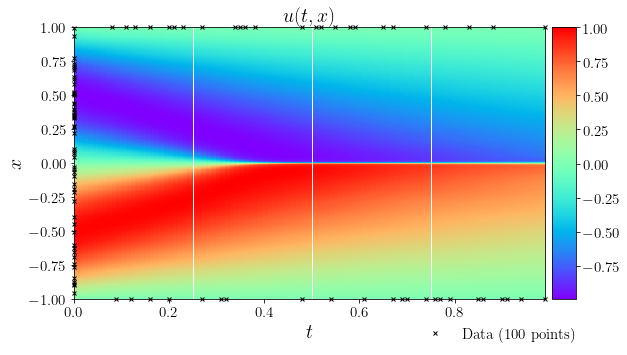

In [9]:
#画图，基本摘抄原作者TensorFlow版
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) 
ax.tick_params(labelsize=15)

plt.show()

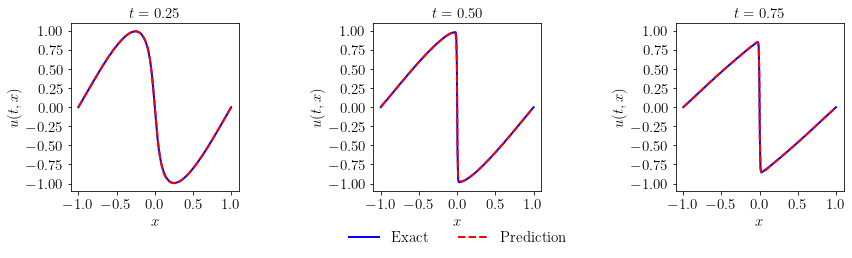

In [10]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()